## Latitude bands recycling
- running with merged data (zero evap over ocean) over three different band options
- running with rotation options and plotting seasonal averages for all rotations

In [10]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import sys 
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.pyplot as plt
import time as timer
start_all = timer.time()

In [11]:
YR = 1990
dataf ="/Volumes/ESA_F4R/era/" 
datao ="/Volumes/ESA_F4R/ed_prepare/" 
datap ="/Volumes/ESA_F4R/ed_prepare/bands_rho/plots/" 
datas ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/Shapefiles/"
shp_cod = gpd.read_file(datas+"congo_basin_evergreen.shp")

### Band definitions used
- North: 5-12**N** / 10-31**E**
- Equatorial: 5**S**-5**N** / 8-29**E**
- South: 15-5**S** / 12-31**E**

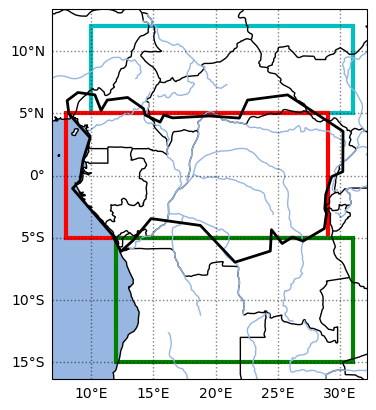

<Figure size 640x480 with 0 Axes>

In [12]:
band = {'N':[5,12,10,31],'EQ':[-5,5,8,29],'S':[-15,-5,12,31]}
B = 'EQ'

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_patch(plt.Rectangle((10, 5), 21, 7, ls="-", lw=3, ec="c", fc="none"))
ax.add_patch(plt.Rectangle((8, -5), 21, 10, ls="-", lw=3, ec="r", fc="none"))
ax.add_patch(plt.Rectangle((12, -15), 19, 10, ls="-", lw=3, ec="g", fc="none"))
shp_cod.plot(ax=ax, edgecolor='black',facecolor='none',lw=2,zorder=2,linestyle='-')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
plt.show()
plt.clf()

#### **Read in pre-processed files that have the following conversions:**

**Read in ERA5 data on pressure levels (hourly timesteps in fortnightly files)**
- *fortnightly files currently run from 1994-2024*
- resampled to monthly MS timestep
- shum multiplied by 1000 to convert from kg/kg --> g/kg
- pressure levels are divided by 100 to convert from Pa to hPa (only for fortnightly files)
- sort data by descending pressure levels (only for fortnightly files)


**Input file units:**
- plev - pa
- q - kg/kg
- u - m/s
- v - m/s

**Read in ERA5 land data (hourly in monthly files)**
- selecting hour 23 (0-23) of Prec and Evap because of how ERA5 Land variables are accumulated (https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790 - https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-accumulationsAccumulations)
- prec is multiplied by 1000 to convert from m to mm
- evap is multiplied by -1000 to convert from m to mm and upward fluxes in land model are considered negative
- Prec, Evap, and Psfc are then resampled to MS monthly and also interpolated to coarser pressure level grid

**Input file units:**
- tp - m
- e - m (-)
- sp - pa

**Merging all input datasets into one dataset for recyling code called ds**
- close both input datasets
- sort everything so latitude is south to north
- transpose dimensions so they run (lon,lat,level,time) as in recycling code
- save input ds to file

**Integrate zonal and meridional moisture flux**
- ***To do:*** do this with hourly data to test difference in rho
- **Must check if there are any nans in input arrays** - there can be none because we are using nans as an indicator in the modified definitions

False
41820
Number of nans in Evap:  0
Number of nans in Prec:  0
Number of nans in Psfc:  0
Number of nans in Uwnd:  0
Number of nans in Vwnd:  0
Number of nans in Shum:  0


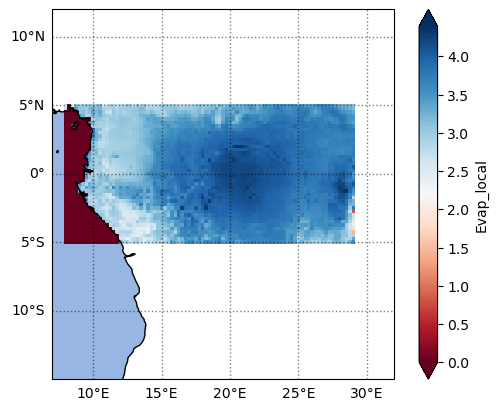

False
41820


<Figure size 640x480 with 0 Axes>

In [13]:
ds = xr.open_dataset(datao+"merge_int_ds/merge_erads_"+str(YR)+".nc")

#Running the code with an irregular boundary means that there will be nans once the data is clipped
#For this to work properly it is important that there are no nans in the input data which would 
#actually be missing data where recycling will be calculated
print(np.isnan(ds['Evap'].values).any())
print(ds['Evap'].isnull().count().values)
print('Number of nans in Evap: ', ds['Evap'].where(np.isnan(ds['Evap'])==True,drop=True).count().values)
print('Number of nans in Prec: ', ds['Prec'].where(np.isnan(ds['Prec'])==True,drop=True).count().values)
print('Number of nans in Psfc: ', ds['Psfc'].where(np.isnan(ds['Psfc'])==True,drop=True).count().values)
print('Number of nans in Uwnd: ', ds['Uwnd'].where(np.isnan(ds['Uwnd'])==True,drop=True).count().values)
print('Number of nans in Vwnd: ', ds['Vwnd'].where(np.isnan(ds['Vwnd'])==True,drop=True).count().values)
print('Number of nans in Shum: ', ds['Shum'].where(np.isnan(ds['Shum'])==True,drop=True).count().values)

#Clip out specific band
ds = ds.transpose("time","level","lat","lon",missing_dims='ignore')
ds = ds.sel(lon=slice(band[B][2],band[B][3]),lat=slice(band[B][0],band[B][1]))
ds['Evap_local'] = ds['Evap'].fillna(0.0)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ds['Evap_local'].mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.RdBu,
                                       extend="both")

ax.set_extent([7, 32, -15, 12])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
#ax.set_title()
#plt.savefig()
plt.show()
plt.clf()
          
ds = ds.transpose("lon","lat","level","time",missing_dims='ignore')
print(np.isnan(ds['Evap_local'].values).any())
print(ds['Evap_local'].isnull().count().values)

In [14]:
#Prepping datasets near surface for recycling
import bulk_recycling_model.numerical_integration

# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

**Prepare scaled data for recycling code**
- Evaporation and moisture fluxes


In [15]:
# Prepare and scale the data
from bulk_recycling_model import preprocess
from bulk_recycling_model import ED_preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")

# make a scaling object to convert between unit systems
scaling = Scaling(H)

dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

# convert E to scaled units
# Do this for both the total E and the local regionally clipped E]
#print('pre-scaled',ds['Evap'])
E_total = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)
E_local = scaling.evaporation.convert(ds["Evap_local"].values, UnitSystem.natural, UnitSystem.scaled)

L = 2.33e+06 m
dx = 2.74e+04 m
H = 1.11e+06 m
dy = 2.71e+04 m
dx = 2.47e-02 scaled
dy = 2.44e-02 scaled


**Plot the scaled E array**


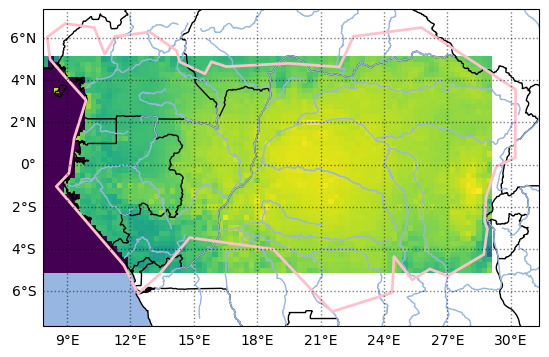

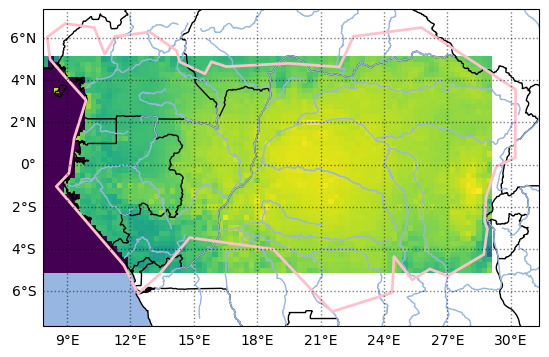

<Figure size 640x480 with 0 Axes>

In [16]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
#Overlay with all ward outline
shp_cod.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
#Plot data
Ea = np.transpose(np.average(E_total,axis=2))
collection = plt.pcolormesh(ds['Evap'].lon, ds['Evap'].lat,Ea)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
#ax.set_title()
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
#Overlay with all ward outline
shp_cod.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
#Plot data
Ea = np.transpose(np.average(E_local,axis=2))
collection = plt.pcolormesh(ds['Evap'].lon, ds['Evap'].lat,Ea)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
#ax.set_title()
#plt.savefig()
plt.show()
plt.clf()

**Run recycling model for each timestep**
- Create recycling output array based on the shape of one of the surface input files: evap 
- Translate evap and fluxes to secondary grid
- Calculate modeled precipitation
- Plot scaled input variables (evap and fluxes)
- Run through each timestep in the input files and calculate recycling ratio at each timestep across domain
- Plot rho and convergence metric for each timestep

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 276 iterations and 0:00:02.508207
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 273 iterations and 0:00:02.322785
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Converged in 228 iterations and 0:00:01.984007
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 245 iterations and 0:00:02.023660


0 1990-01-01T00:00:00.000000000
Rotation is:  3
228


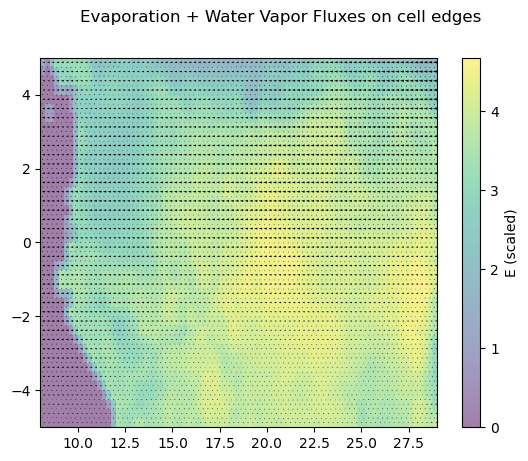

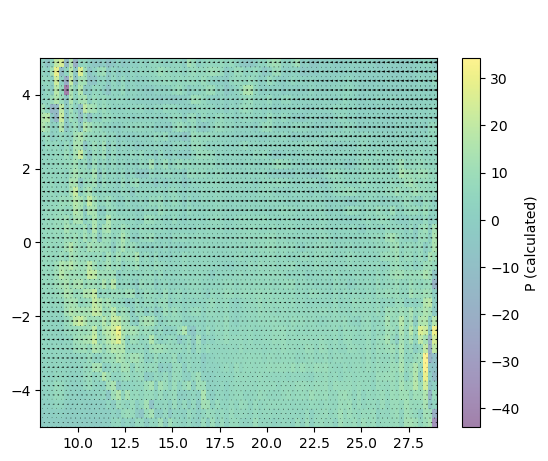

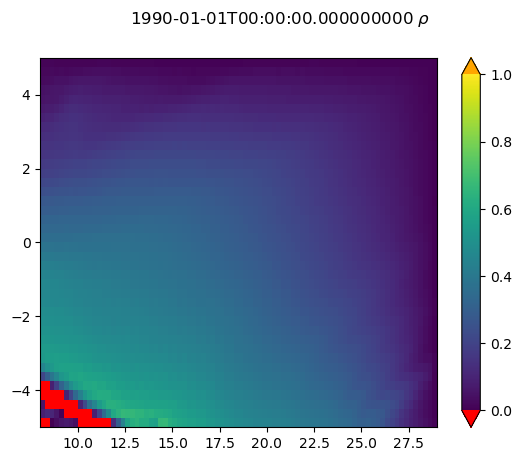

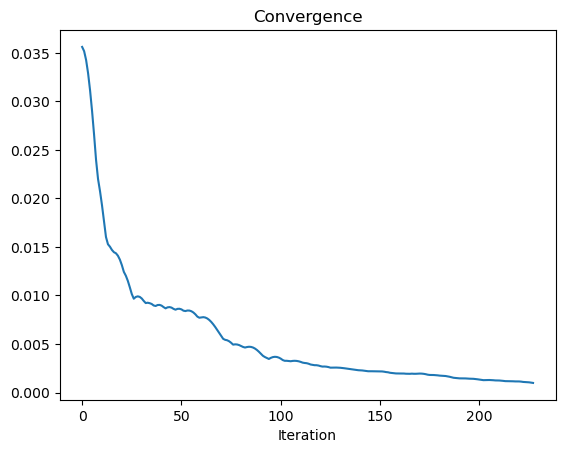

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees


1 1990-02-01T00:00:00.000000000
Rotation is:  3
500


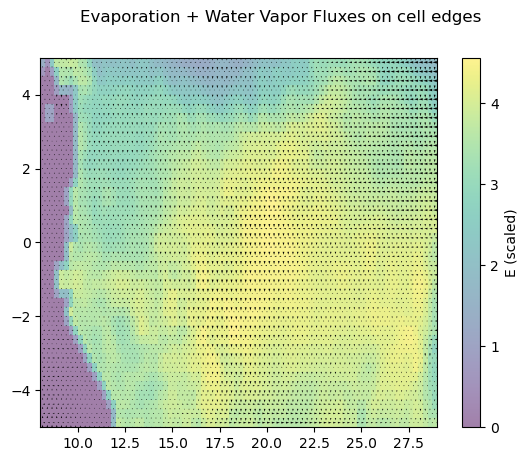

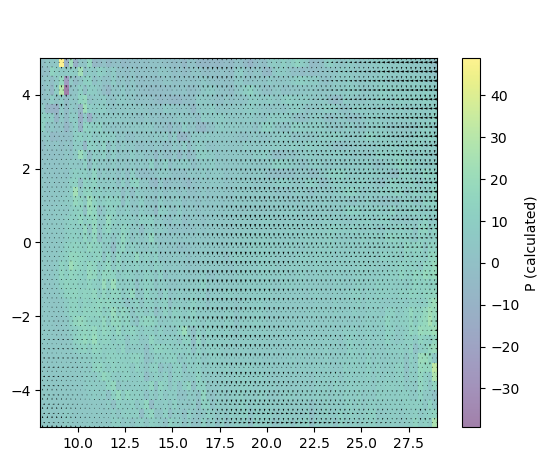

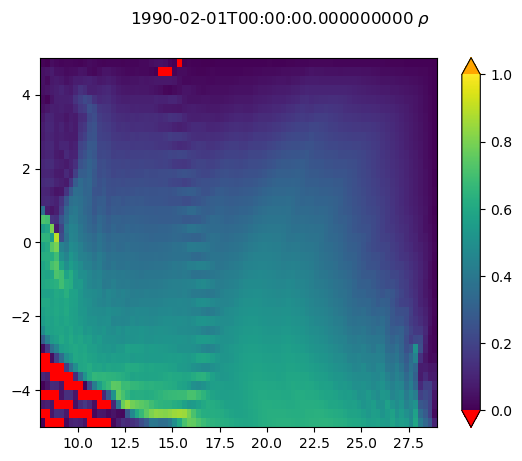

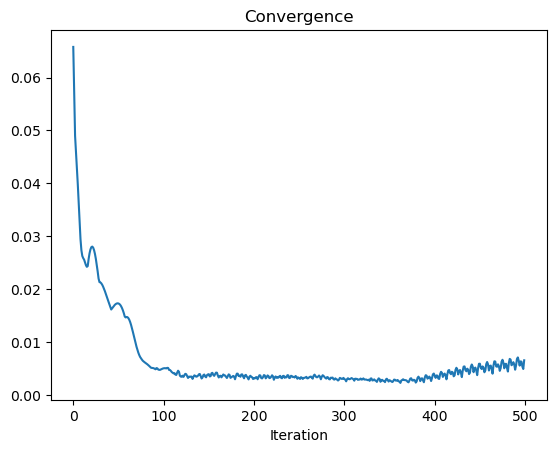

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 312 iterations and 0:00:02.711778
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 296 iterations and 0:00:02.440553
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Converged in 221 iterations and 0:00:01.874697
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 241 iterations and 0:00:01.979741


2 1990-03-01T00:00:00.000000000
Rotation is:  3
221


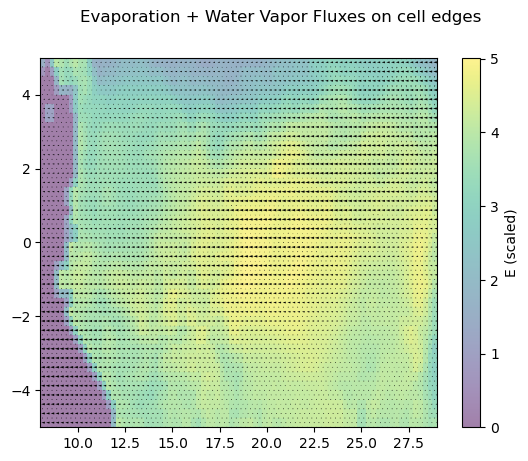

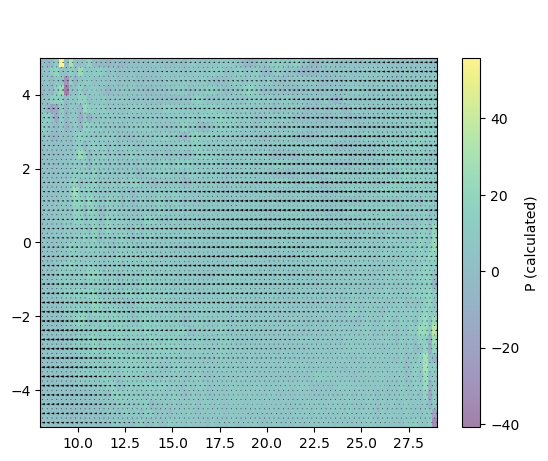

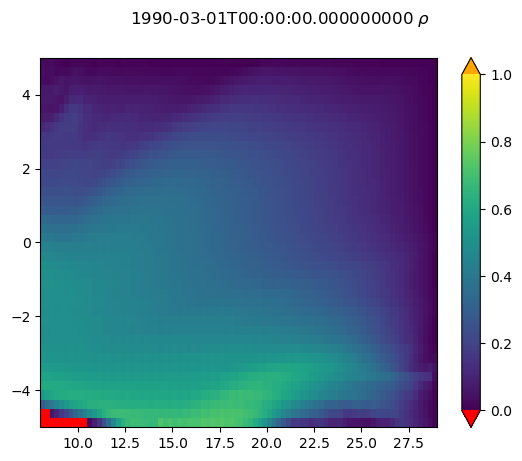

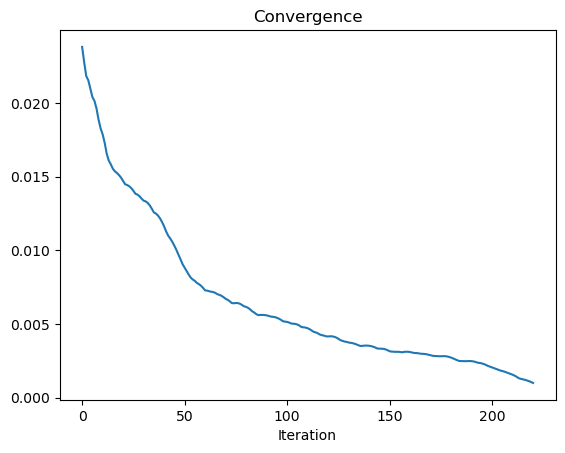

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 308 iterations and 0:00:02.594008
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 234 iterations and 0:00:01.981456


3 1990-04-01T00:00:00.000000000
Rotation is:  3
500


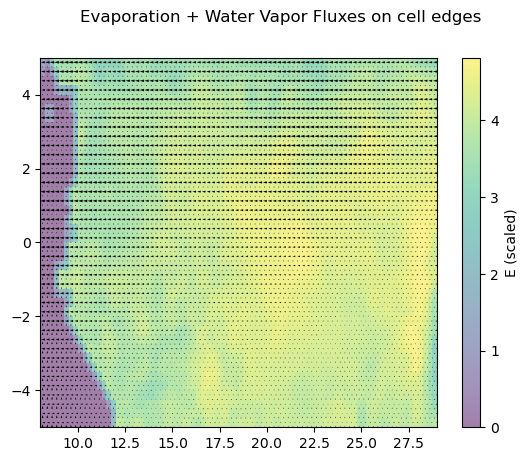

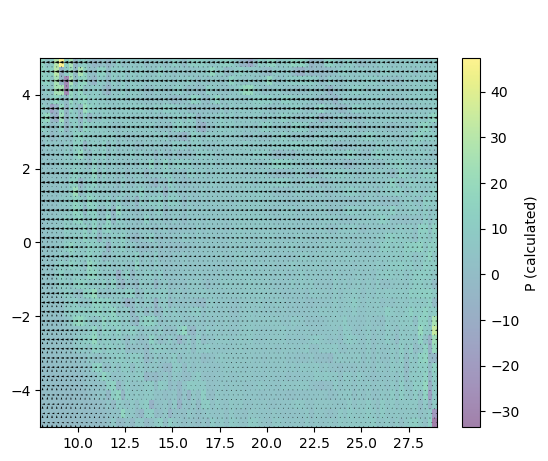

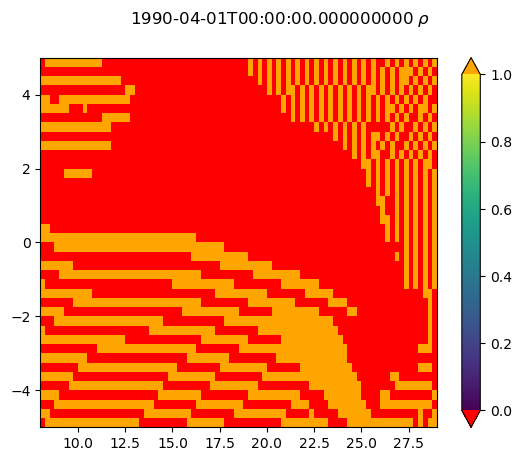

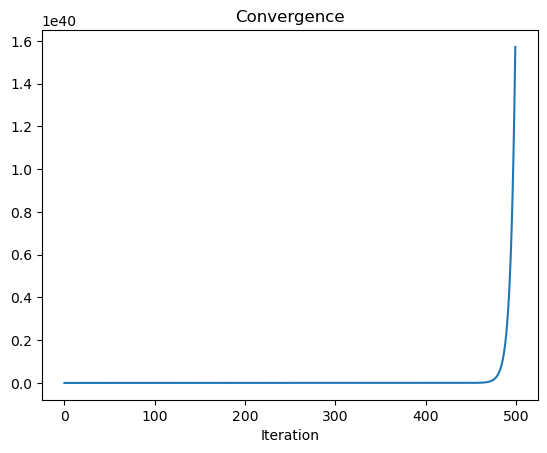

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 311 iterations and 0:00:02.628121
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 339 iterations and 0:00:02.847125
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Converged in 264 iterations and 0:00:02.305332
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 235 iterations and 0:00:01.964487


4 1990-05-01T00:00:00.000000000
Rotation is:  3
264


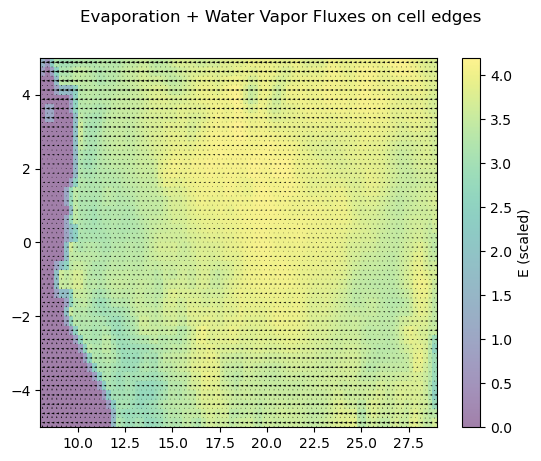

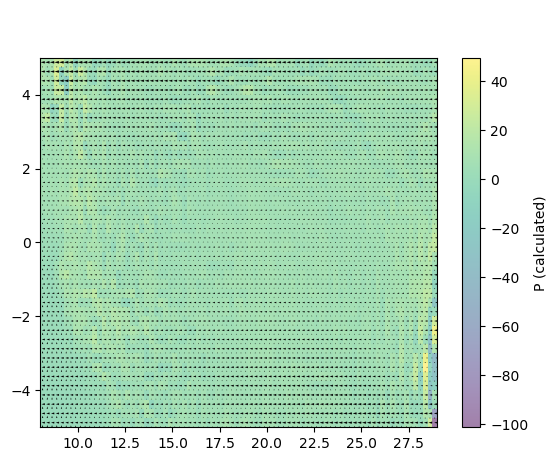

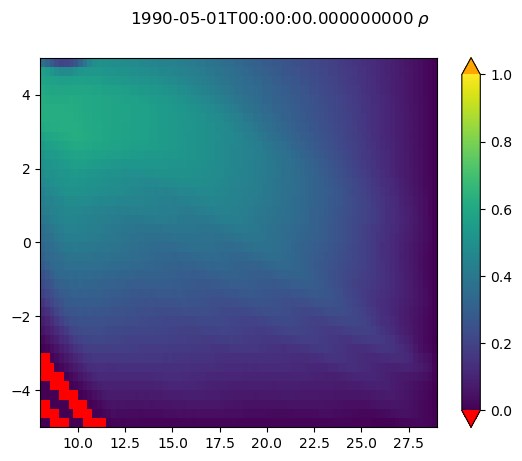

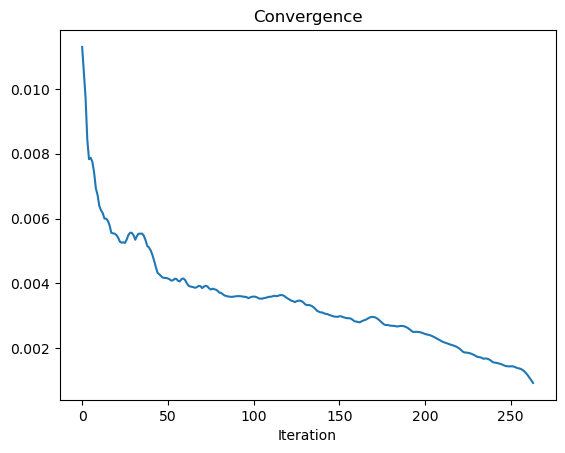

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees


5 1990-06-01T00:00:00.000000000
Rotation is:  3
500


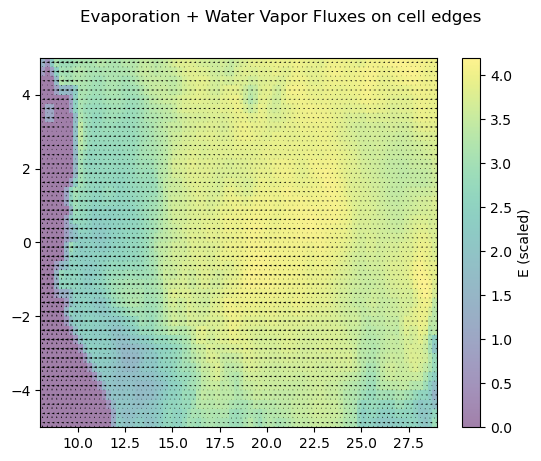

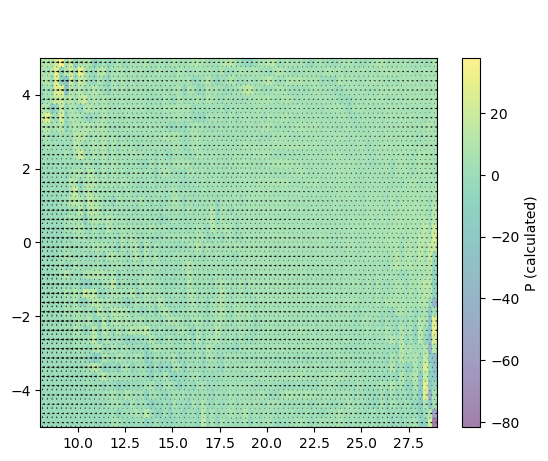

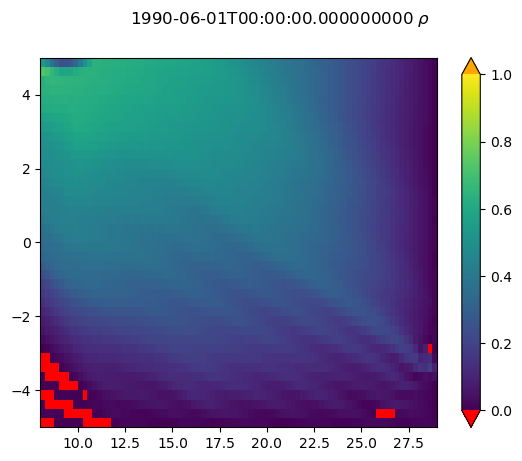

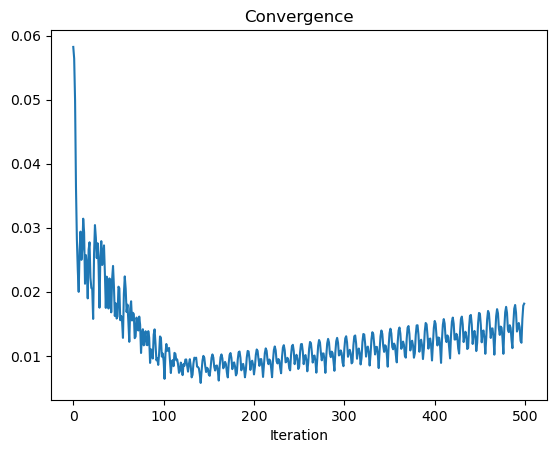

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees


6 1990-07-01T00:00:00.000000000
Rotation is:  3
500


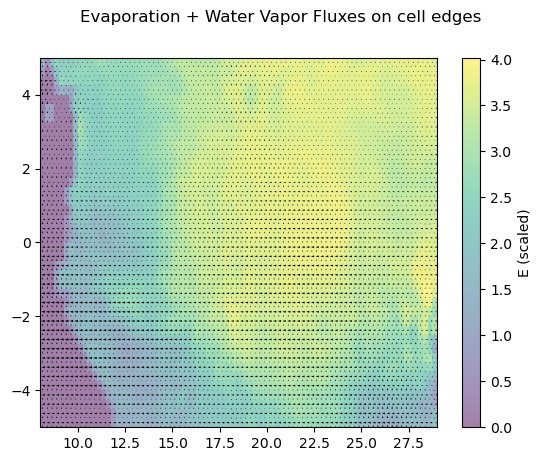

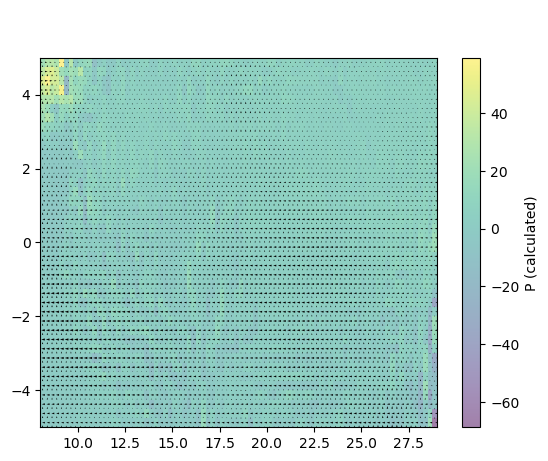

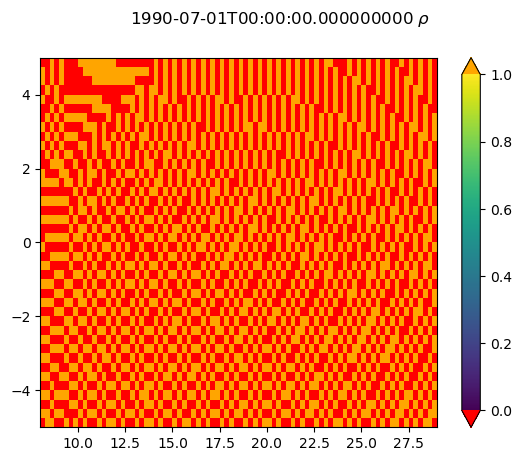

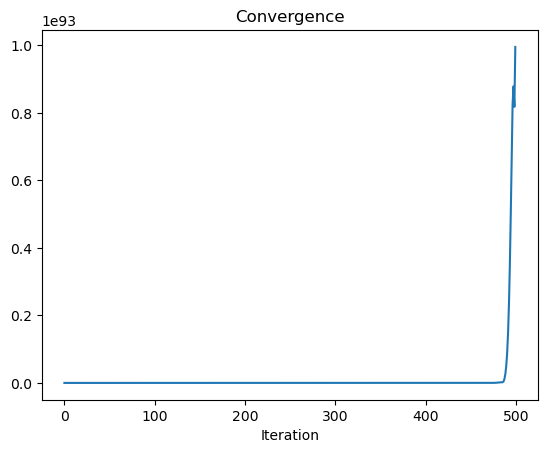

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 268 iterations and 0:00:02.343224
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 295 iterations and 0:00:02.447781
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Converged in 269 iterations and 0:00:02.334987
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 245 iterations and 0:00:02.056693


7 1990-08-01T00:00:00.000000000
Rotation is:  3
269


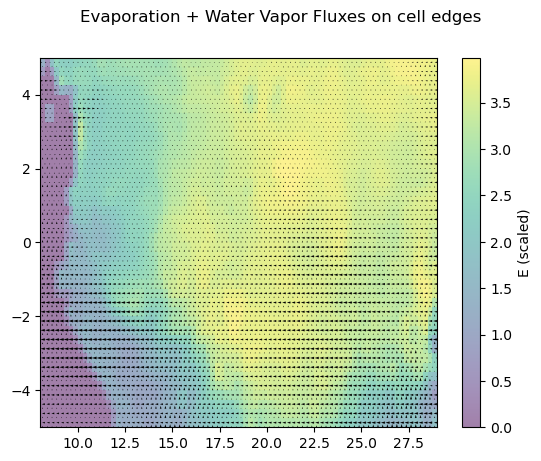

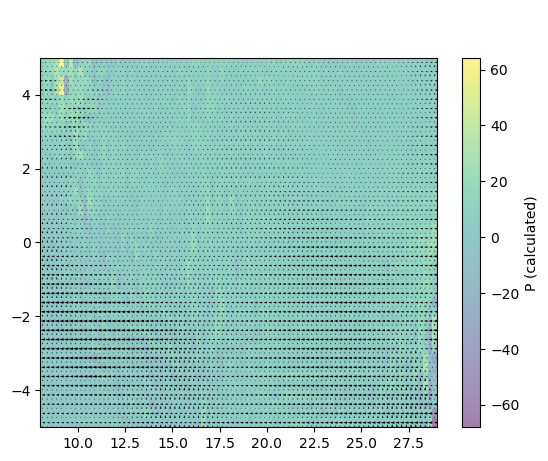

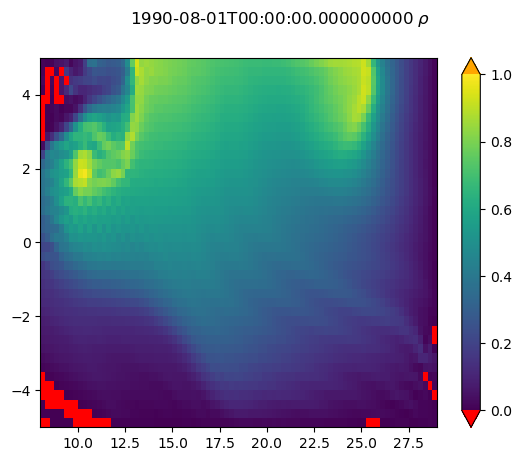

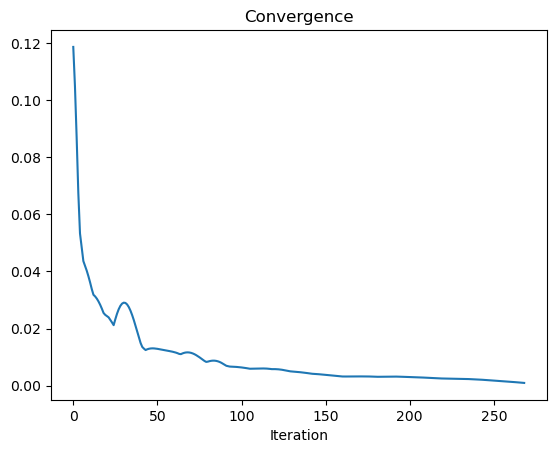

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 239 iterations and 0:00:02.001177
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees


8 1990-09-01T00:00:00.000000000
Rotation is:  3
500


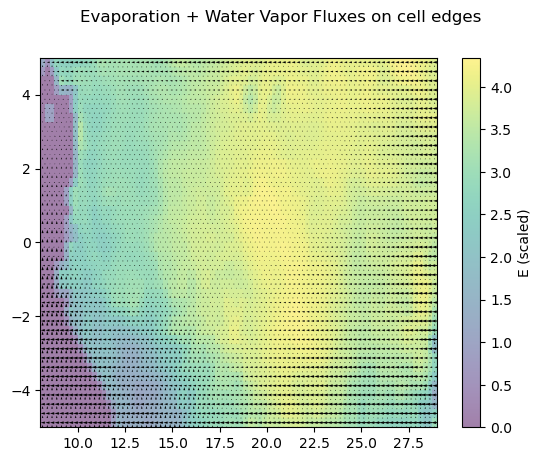

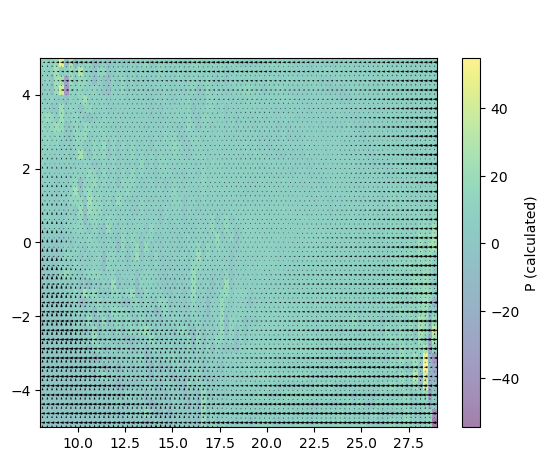

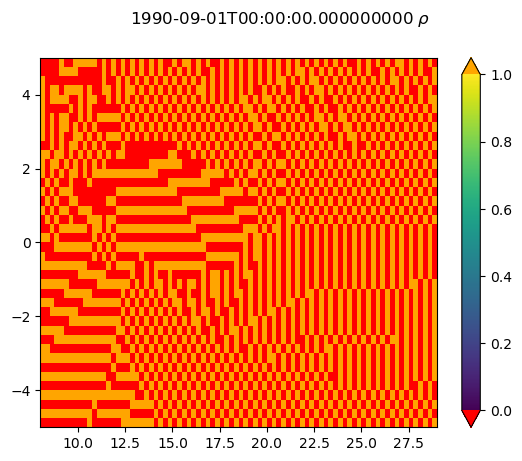

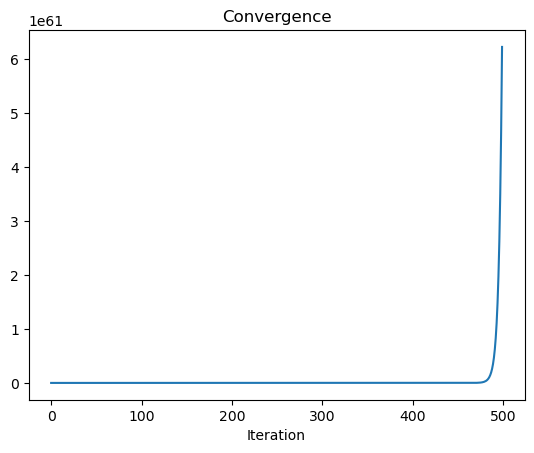

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 296 iterations and 0:00:02.548827
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 296 iterations and 0:00:02.485615
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Converged in 240 iterations and 0:00:02.071337
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 235 iterations and 0:00:01.985343


9 1990-10-01T00:00:00.000000000
Rotation is:  3
240


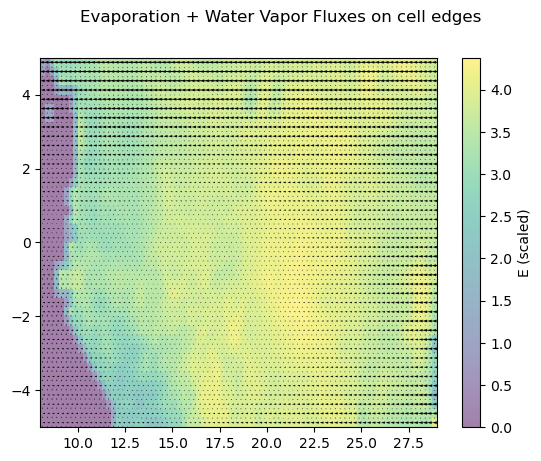

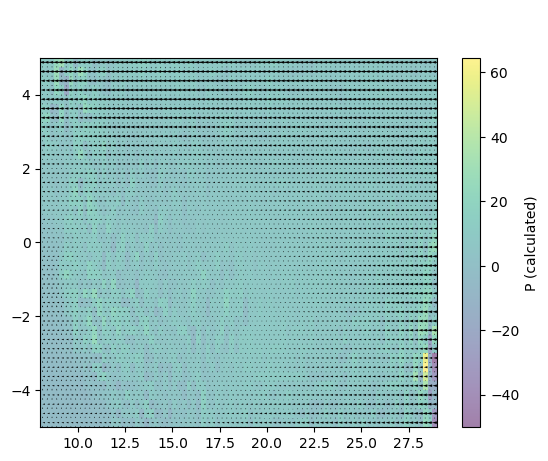

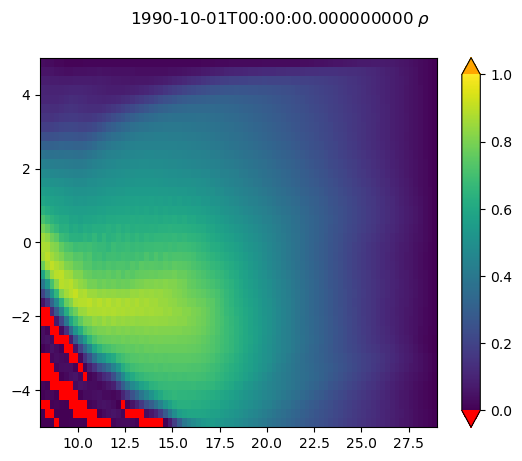

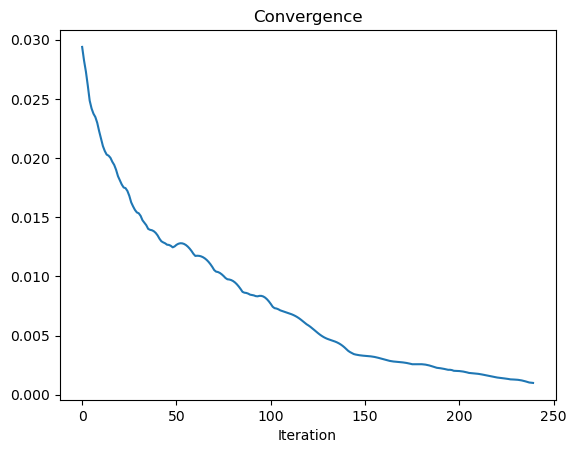

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 290 iterations and 0:00:02.522979
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 281 iterations and 0:00:02.339111
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Converged in 204 iterations and 0:00:01.788023
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 213 iterations and 0:00:01.700748


10 1990-11-01T00:00:00.000000000
Rotation is:  3
204


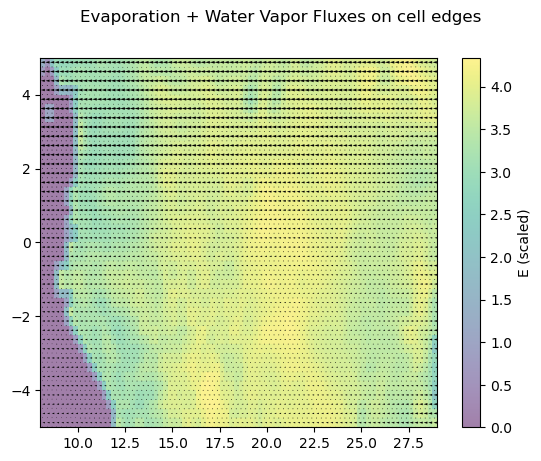

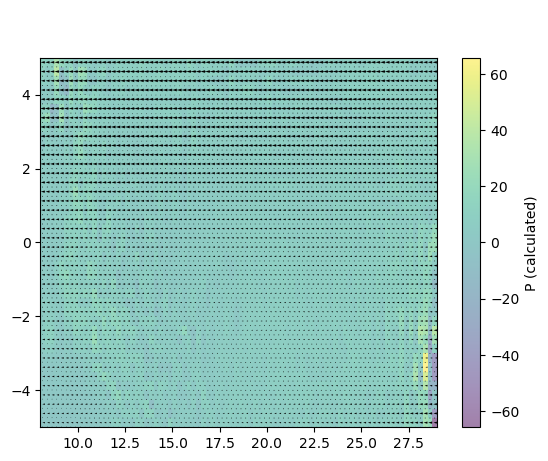

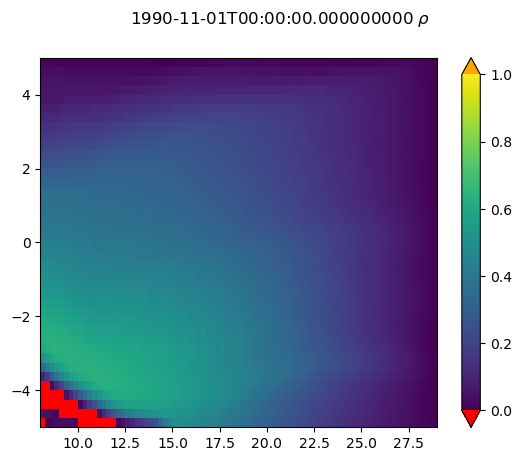

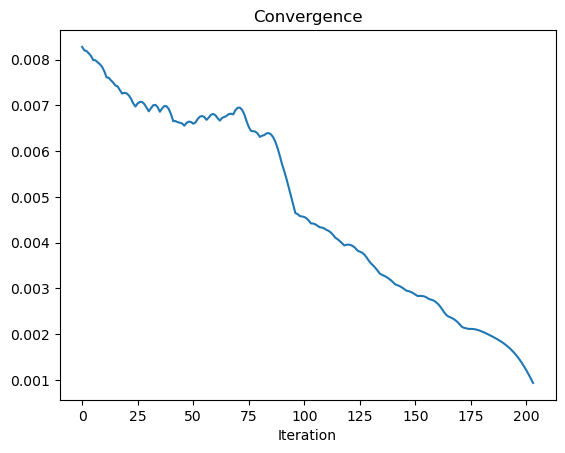

INFO:bulk_recycling_model.main:Attempt 1 of 4 with rotation of 0 degrees
INFO:bulk_recycling_model.main:Converged in 309 iterations and 0:00:02.602105
INFO:bulk_recycling_model.main:Attempt 2 of 4 with rotation of 90 degrees
INFO:bulk_recycling_model.main:Converged in 297 iterations and 0:00:02.381920
INFO:bulk_recycling_model.main:Attempt 3 of 4 with rotation of 180 degrees
INFO:bulk_recycling_model.main:Converged in 221 iterations and 0:00:01.854334
INFO:bulk_recycling_model.main:Attempt 4 of 4 with rotation of 270 degrees
INFO:bulk_recycling_model.main:Converged in 235 iterations and 0:00:01.869955


11 1990-12-01T00:00:00.000000000
Rotation is:  3
221


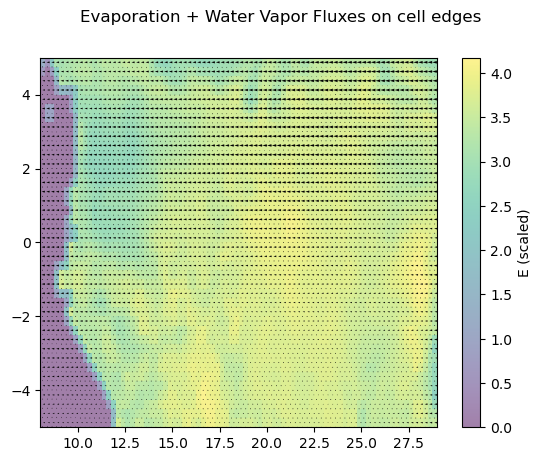

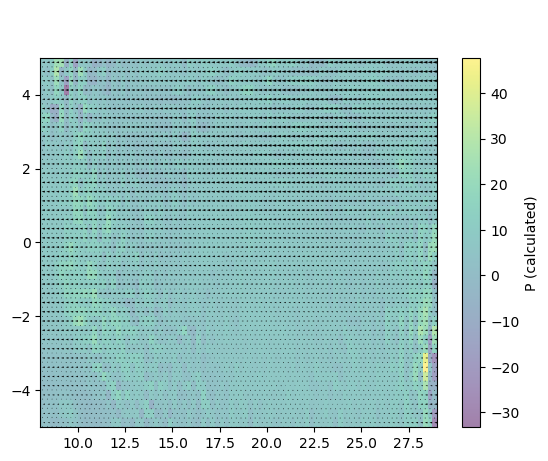

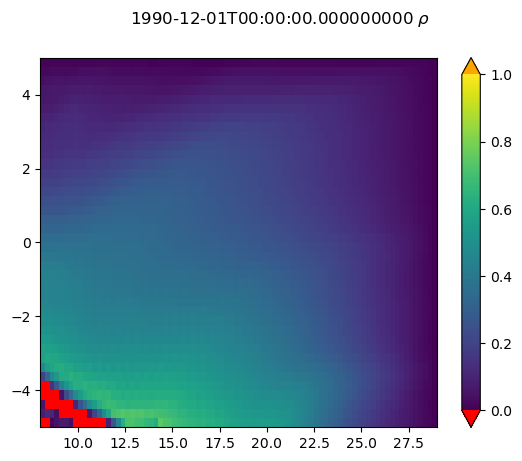

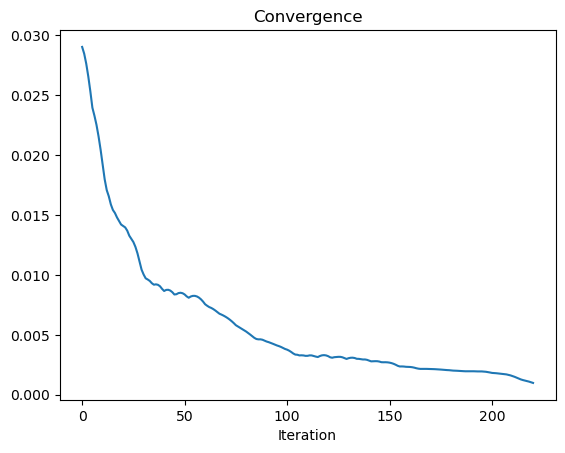

In [17]:
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger("bulk_recycling_model").setLevel(logging.INFO)
from bulk_recycling_model import plotting
from bulk_recycling_model.main import run_4_orientations

#Make the rho array the same shape as the total E - will clip the external points at the end
rho_ar = np.empty((4,np.shape(E_total)[0]-1,np.shape(E_total)[1]-1,np.shape(E_total)[2]))
#Entering preprocessing and time step loop
#Run model and plot
for i,time in enumerate(ds.time):
     
    # preprocess E onto the secondary grid
    Ei_total = ED_preprocess.prepare_E(E_total[:,:,i])
    Ei_local = ED_preprocess.prepare_E(E_local[:,:,i])
    
    # preprocess water vapor fluxes onto the secondary grid
    Fxi_left = preprocess.prepare_Fx_left(Fx[:,:,i])
    Fxi_right = preprocess.prepare_Fx_right(Fx[:,:,i])
    Fyi_bottom = preprocess.prepare_Fy_bottom(Fy[:,:,i])
    Fyi_top = preprocess.prepare_Fy_top(Fy[:,:,i])
    
    # compute P
    Pi = preprocess.calculate_precipitation(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, Ei_total, dx, dy)

#    # Create a quiver plot
#    fig, ax = plt.subplots()
#    U,V = plotting.build_uv_fluxes(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top)
#    X, Y = np.meshgrid(lon_axis.half_step, lon_axis.half_step, indexing="ij")
#    ax.quiver(X[::2, ::2],Y[::2, ::2],U[::2, ::2],V[::2, ::2])
#    fig.suptitle("Water Vapor Fluxes on cell edges")
    
    # Create a quiver plot
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, Ei_local, lon_axis, lat_axis, alpha=0.5)
    fig.colorbar(collection, label="E (scaled)")
    plotting.quiver(ax, Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, lon_axis, lat_axis)
    fig.suptitle("Evaporation + Water Vapor Fluxes on cell edges")
    
    # Create a precip plot
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, Pi, lon_axis, lat_axis, alpha=0.5)
    fig.colorbar(collection, label="P (calculated)")
    plotting.quiver(ax, Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, lon_axis, lat_axis)
    fig.suptitle(" ")
    
    # Run the model
    status = run_4_orientations(
        Fxi_left,
        Fxi_right,
        Fyi_bottom,
        Fyi_top,
        Ei_local,
        Pi,
        dx,
        dy,
        R=0.2,
        R_1=0.2,
        max_iter=500,
        tol=1e-3,
    )
#    for k, run_status in status.items():
#    print(f"Rotation {k * 90} degrees")
#    print(f"    success = {run_status["success"]}")
#    print(f"    number of iterations = {run_status["k"]}")
#    rho = [s["rho"] for s in status.values()]
#    # compare the solutions pairwise
#    for i in range(4):
#        for j in range(i + 1, 4):
#            diff = np.abs(rho[i] - rho[j]).max()
#            print(f"Max abs diff between k={i} and k={j}: {diff}")
        
    #Print timestep and status (converged or not) and add rho to recycling ration array
    rot = 2
    print(i,time.values)
    print('Rotation is: ',rot+1)
    print(status[rot]['k'])
    rho_ar[0,:,:,i] = status[0]["rho"]
    rho_ar[1,:,:,i] = status[1]["rho"]
    rho_ar[2,:,:,i] = status[2]["rho"]
    rho_ar[3,:,:,i] = status[3]["rho"]

    # plot each timestep 
    fig, ax = plt.subplots()
    cmap=plt.cm.viridis
    cmap.set_extremes(under='red', over='orange')
    collection = plotting.pcolormesh(ax, status[rot]["rho"], lon_axis, lat_axis,
                                     vmin=0.0, vmax=1,
                                     cmap=cmap)
    fig.colorbar(collection,extend='both')
    fig.suptitle(str(time.values)+" $\\rho$")
    #plt.savefig(datap+"rho_"+str(time.values)+".png")
    plt.show()
    plt.close()
    
    # plot the convergence
    deltas = status[rot]["deltas"]
    fig, ax = plt.subplots()
    ax.plot(deltas)
    ax.set_title("Convergence")
    ax.set_xlabel("Iteration")
    plt.show()
    plt.close()

**Create and save rho xarray file**

- Create an xarray to store all of the calculated recycling ratios that is organised in an easy to plot/interpret format
- Count number of values in array over 1 - replace all of these with 1
- Count number of negative rho values - replace all of these with zero
- Save to file

In [18]:
lon_ar = np.linspace(start=ds.coords["lon"].min().values+lon_axis.step/2,
                     stop=ds.coords["lon"].max().values-lon_axis.step/2,
                     num=lon_axis.n_points-1)
lat_ar = np.linspace(start=ds.coords["lat"].min().values+lat_axis.step/2,
                     stop=ds.coords["lat"].max().values-lat_axis.step/2,
                     num=lat_axis.n_points-1)
rho_xarr = xr.Dataset(
    data_vars=dict(rho=(["rot","lon","lat","time"],rho_ar)),
    coords=dict(
        rot=(["rot"],[1,2,3,4]),
        lon=(["lon"], lon_ar),
        lat=(["lat"], lat_ar),
        time=(["time"],ds.time.data)
    ),
    attrs=dict(
        description="Recycling ratio",
        units="%",
    ),
) 
rho_xarr = rho_xarr.transpose("rot","time","lat","lon")
rho_xarr.to_netcdf(datao+"bands_int_rho/band_rot_rho_era5_"+str(YR)+".nc")

In [19]:
#Filtering out outliers for plotting 
for r in np.arange(1,5):
    print("*** Rotation is: ",r)
    print('Number of rhos over 1: ', rho_xarr['rho'][r-1,:,:,:].where(rho_xarr['rho'][r-1,:,:,:].values>1.0).count().values)
    print('Number of negative rhos: ', rho_xarr['rho'][r-1,:,:,:].where(rho_xarr['rho'][r-1,:,:,:].values<0.0).count().values)
    rho_xarr['rho'][r-1,:,:,:] = rho_xarr['rho'][r-1,:,:,:].where(rho_xarr['rho'][r-1,:,:,:].values<=1.0,1.0)
    rho_xarr['rho'][r-1,:,:,:] = rho_xarr['rho'][r-1,:,:,:].where(rho_xarr['rho'][r-1,:,:,:].values>0.0,0.0)
    print('Number of rhos over 1: ', rho_xarr['rho'][r-1,:,:,:].where(rho_xarr['rho'][r-1,:,:,:].values>1.0).count().values)
    print('Number of negative rhos: ', rho_xarr['rho'][r-1,:,:,:].where(rho_xarr['rho'][r-1,:,:,:].values<0.0).count().values)
    print('-------------------------')
end_all = timer.time()
length = end_all - start_all
print("Running the whole prep and recycling code took ", length, "seconds")


*** Rotation is:  1
Number of rhos over 1:  3387
Number of negative rhos:  3753
Number of rhos over 1:  0
Number of negative rhos:  0
-------------------------
*** Rotation is:  2
Number of rhos over 1:  2803
Number of negative rhos:  4326
Number of rhos over 1:  0
Number of negative rhos:  0
-------------------------
*** Rotation is:  3
Number of rhos over 1:  4461
Number of negative rhos:  5976
Number of rhos over 1:  0
Number of negative rhos:  0
-------------------------
*** Rotation is:  4
Number of rhos over 1:  3145
Number of negative rhos:  4002
Number of rhos over 1:  0
Number of negative rhos:  0
-------------------------
Running the whole prep and recycling code took  149.66894721984863 seconds


**Plotting**

Create seasonal arrays and plot these

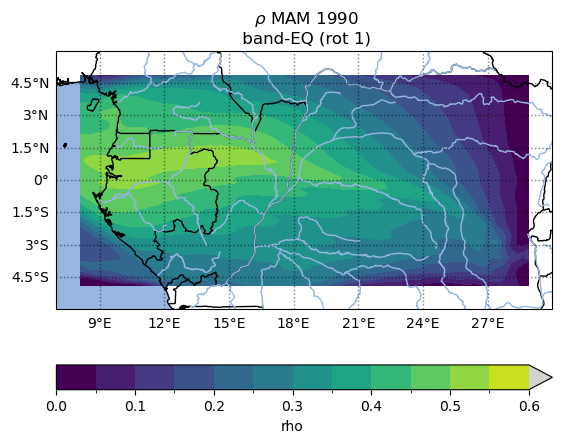

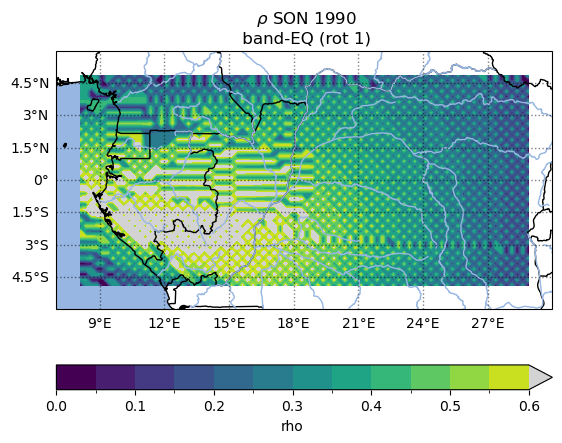

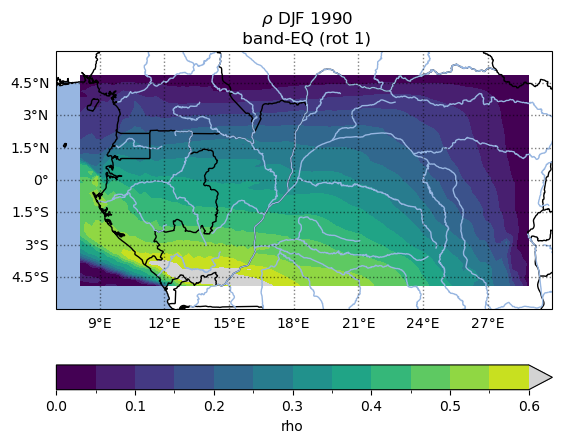

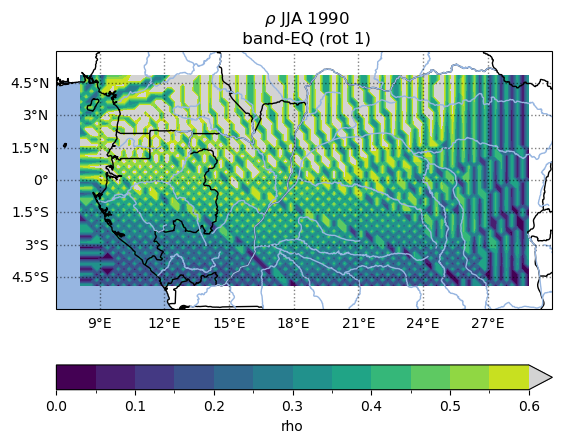

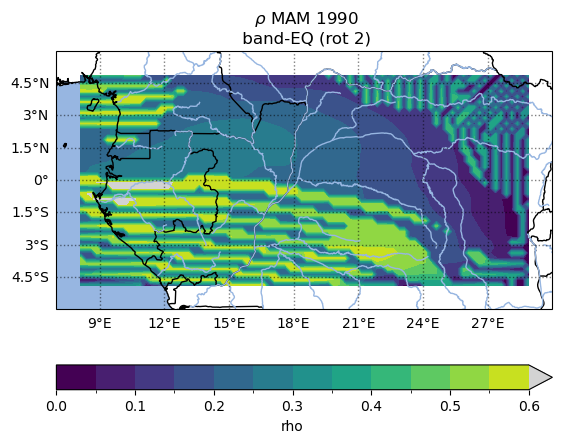

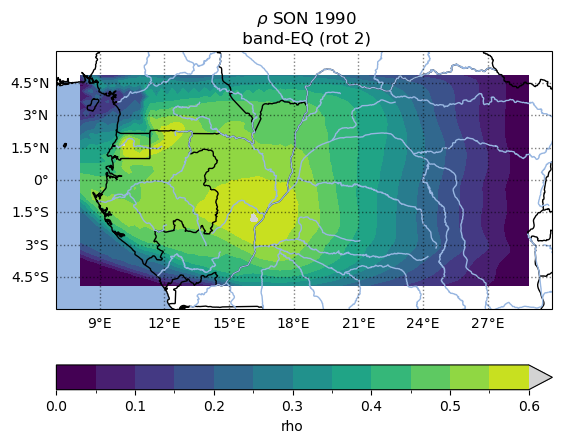

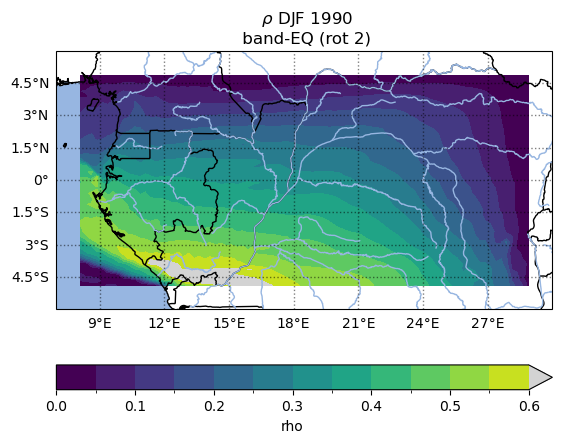

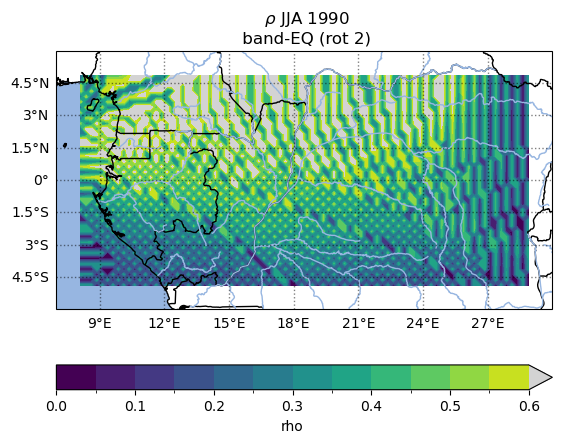

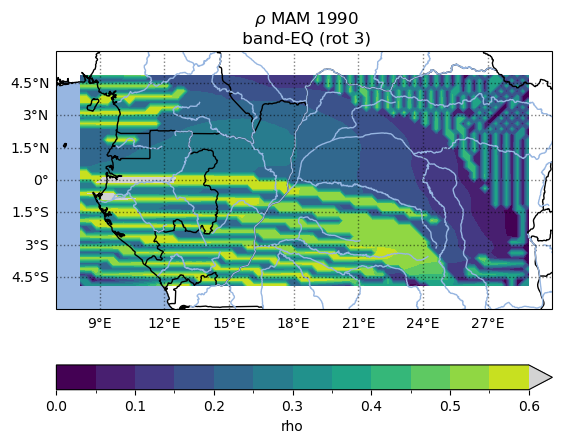

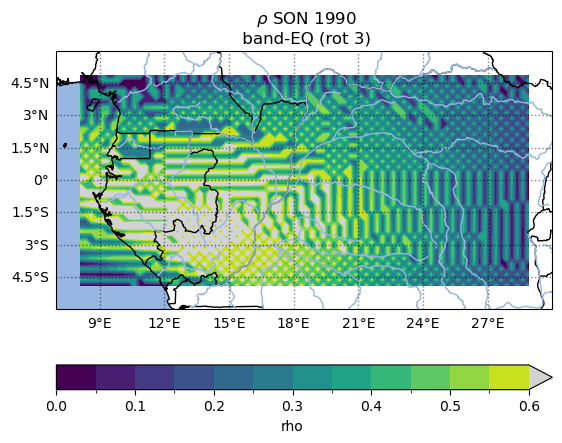

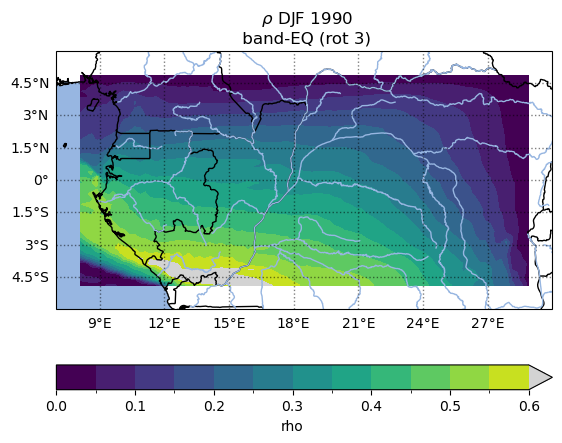

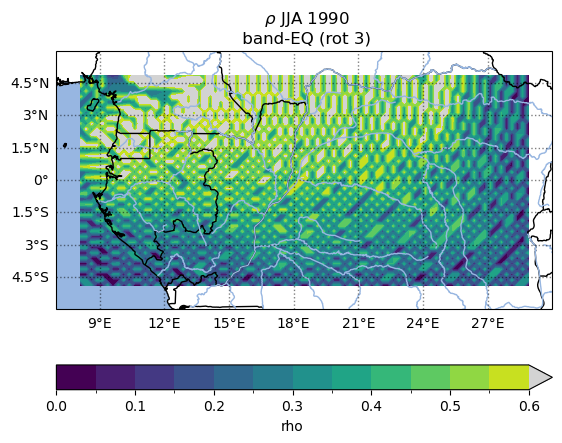

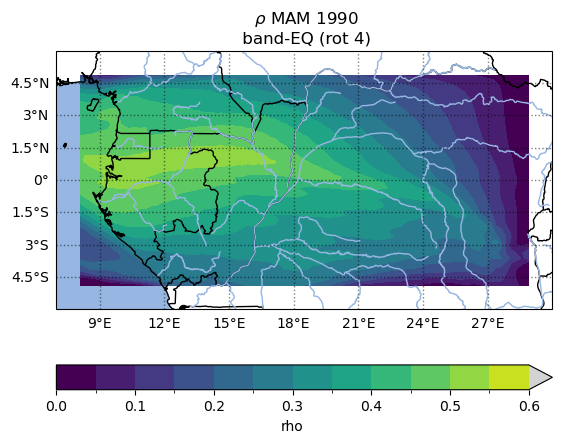

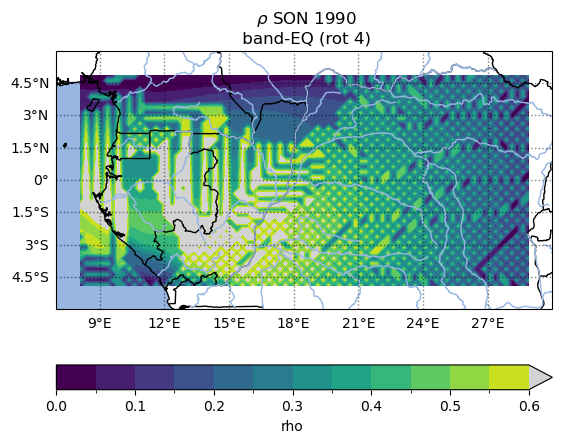

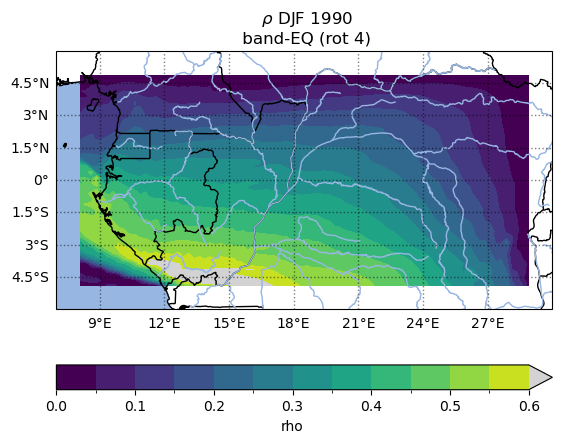

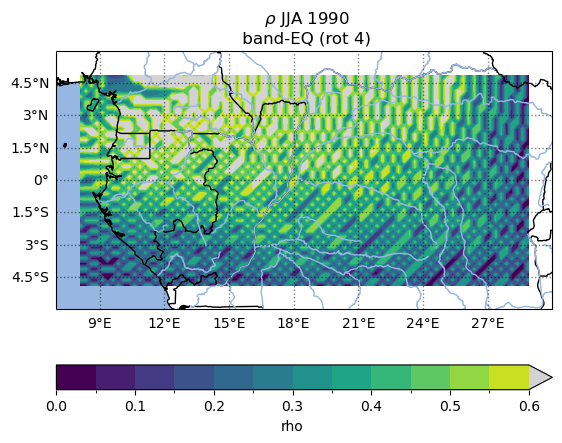

In [20]:
# Create seasonal arrays and plot these
for r in np.arange(1,5):
    rho_plot = rho_xarr['rho'][r-1,:,:,:] 
    mam_rho = rho_plot.sel(time=rho_xarr.time.dt.month.isin([3,4,5]))
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.OCEAN)
    cmap=plt.cm.viridis
    cmap.set_extremes(over='lightgrey')
    collection = mam_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,
                                                    levels=13,ax=ax,extend='max',cmap=cmap,
                                                    cbar_kwargs={"location":"bottom"} )
    ax.set_extent([band[B][2]-1,band[B][3]+1,band[B][0]-1,band[B][1]+1])
    ax.set_title(" $\\rho$"+" MAM "+str(YR)+"\n band-"+B+" (rot "+str(r)+")")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.top_labels = False
    gl.right_labels = False
    plt.savefig(datap+"rho_intdaily_MAM_"+str(YR)+"_"+B+"rot"+str(r)+".png")
    #plt.show()
        
    son_rho = rho_plot.sel(time=rho_xarr.time.dt.month.isin([9,10,11]))
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.OCEAN)
    cmap=plt.cm.viridis
    cmap.set_extremes(over='lightgrey')
    collection = son_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,
                                                    levels=13,ax=ax,extend='max',cmap=cmap,
                                                    cbar_kwargs={"location":"bottom"} )
    ax.set_extent([band[B][2]-1,band[B][3]+1,band[B][0]-1,band[B][1]+1])
    ax.set_title(" $\\rho$"+" SON "+str(YR)+"\n band-"+B+" (rot "+str(r)+")")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.top_labels = False
    gl.right_labels = False
    plt.savefig(datap+"rho_intdaily_SON_"+str(YR)+"_"+B+"rot"+str(r)+".png")
    #plt.show()
    
    djf_rho = rho_plot.sel(time=rho_xarr.time.dt.month.isin([12,1,2]))
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.OCEAN)
    cmap=plt.cm.viridis
    cmap.set_extremes(over='lightgrey')
    collection = djf_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,
                                                    levels=13,ax=ax,extend='max',cmap=cmap,
                                                    cbar_kwargs={"location":"bottom"} )
    ax.set_extent([band[B][2]-1,band[B][3]+1,band[B][0]-1,band[B][1]+1])
    ax.set_title(" $\\rho$"+" DJF "+str(YR)+"\n band-"+B+" (rot "+str(r)+")")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.top_labels = False
    gl.right_labels = False
    plt.savefig(datap+"rho_intdaily_DJF_"+str(YR)+"_"+B+"rot"+str(r)+".png")
    #plt.show()

    jja_rho = rho_plot.sel(time=rho_xarr.time.dt.month.isin([6,7,8]))
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.OCEAN)
    cmap=plt.cm.viridis
    cmap.set_extremes(over='lightgrey')
    collection = jja_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,
                                                    levels=13,ax=ax,extend='max',cmap=cmap,
                                                    cbar_kwargs={"location":"bottom"} )
    ax.set_extent([band[B][2]-1,band[B][3]+1,band[B][0]-1,band[B][1]+1])
    ax.set_title(" $\\rho$"+" JJA "+str(YR)+"\n band-"+B+" (rot "+str(r)+")")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.top_labels = False
    gl.right_labels = False
    plt.savefig(datap+"rho_intdaily_JJA_"+str(YR)+"_"+B+"rot"+str(r)+".png")
    #plt.show()

rho_xarr.close()